<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 3

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* [Car figure](https://korkortonline.se/en/theory/reaction-braking-stopping/)
* [Mathematics for Machine Learning book](https://mml-book.github.io/) and corresponding [jupyter notebook for Chapter 6](https://github.com/vbartle/MML-Companion)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Probability: multivariate models
    - Introduction to joint pdfs
    - Marginal pdfs
    - Conditional pdfs

**Reading material**: This notebook + Chapter 3 (until Section 3.3)

In [2]:
# This cell is hidden during presentation. It's just to define a function to plot the governing model of
# the car stopping distance problem. Defining a function that creates a plot allows to repeatedly run
# this function on cells used in this notebook.
def car_fig(ax):
    real_x = np.linspace(3, 83, 1000)
    real_mu_y = 1.5*real_x + 0.1*(real_x**2) # Recall: E[z*x+0.1*x^2] = E[z]*E[x]+0.1*E[x^2]
    real_sigma_y = np.sqrt( 0.5**2*real_x**2 ) # Recall: V[z*x+x^2] = V[z*x]+V[x^2]=...=sigma_z^2+mu_x^2
    ax.set_xlabel("x (m/s)", fontsize=20) # create x-axis label with font size 20
    ax.set_ylabel("y (m)", fontsize=20) # create y-axis label with font size 20
    ax.set_title("Car stopping distance problem", fontsize=20); # create title with font size 20
    ax.plot(real_x, real_mu_y, 'k:', label="Governing model $\mu_y$")
    ax.fill_between(real_x, real_mu_y - 1.9600 * real_sigma_y,
                    real_mu_y + 1.9600 * real_sigma_y,
                    color='k', alpha=0.2,
                    label='95% confidence interval ($\mu_y \pm 1.96\sigma_y$)') # plot 95% credence interval
    ax.legend(fontsize=15)

## Consider an even simpler car distance problem

<img src="docs/reaction-braking-stopping.svg" title="Car stopping distance" width="25%" align="right">
<br></br>
For now, let's focus on the case where every driver is going at the same velocity $x=75$ m/s.

Then, the governing model is even simpler:

${\color{red}y} = {\color{blue}z}\cdot 75 + 0.1\cdot 75^2 = 75 {\color{blue}z} + 562.5$

- ${\color{red}y}$ is the **output**: the car stopping distance (in meters)
- ${\color{blue}z}$ is a hidden variable: an <a title="random variable">rv</a> representing the driver's reaction time (in seconds)

where $z \sim \mathcal{N}(\mu_z=1.5,\sigma_z^2=0.5^2)$

In [3]:
# Let's make different observations
from scipy.stats import norm # import the normal dist, as we learned before!
# Define our car stopping distance function
def y_for_fixed_x(N_samples):
    x = 75
    samples_z = norm.rvs(1.5, 0.5, size=N_samples) # randomly draw samples from the normal dist.
    samples_y = samples_z*x + 0.1*x**2 # compute the stopping distance for samples of z
    return samples_y # return samples of y

print("Stopping distance for x=75 m/s is:",y_for_fixed_x(N_samples=1)) # drawing random samples of y

Stopping distance for x=75 m/s is: [667.47216143]


### Let's estimate the confidence interval for $x=75$ m/s

- Let's estimate the confidence interval (error bar) using samples of different sizes.

- We will also overlay this with the plot for the governing model (recall **Exercise 2** from Lecture 2)

Empirical mean[y] is 663.6791973558479 (real mean[y]=675)
Empirical std[y] is 42.820019055715214 (real std[y]=37.5)


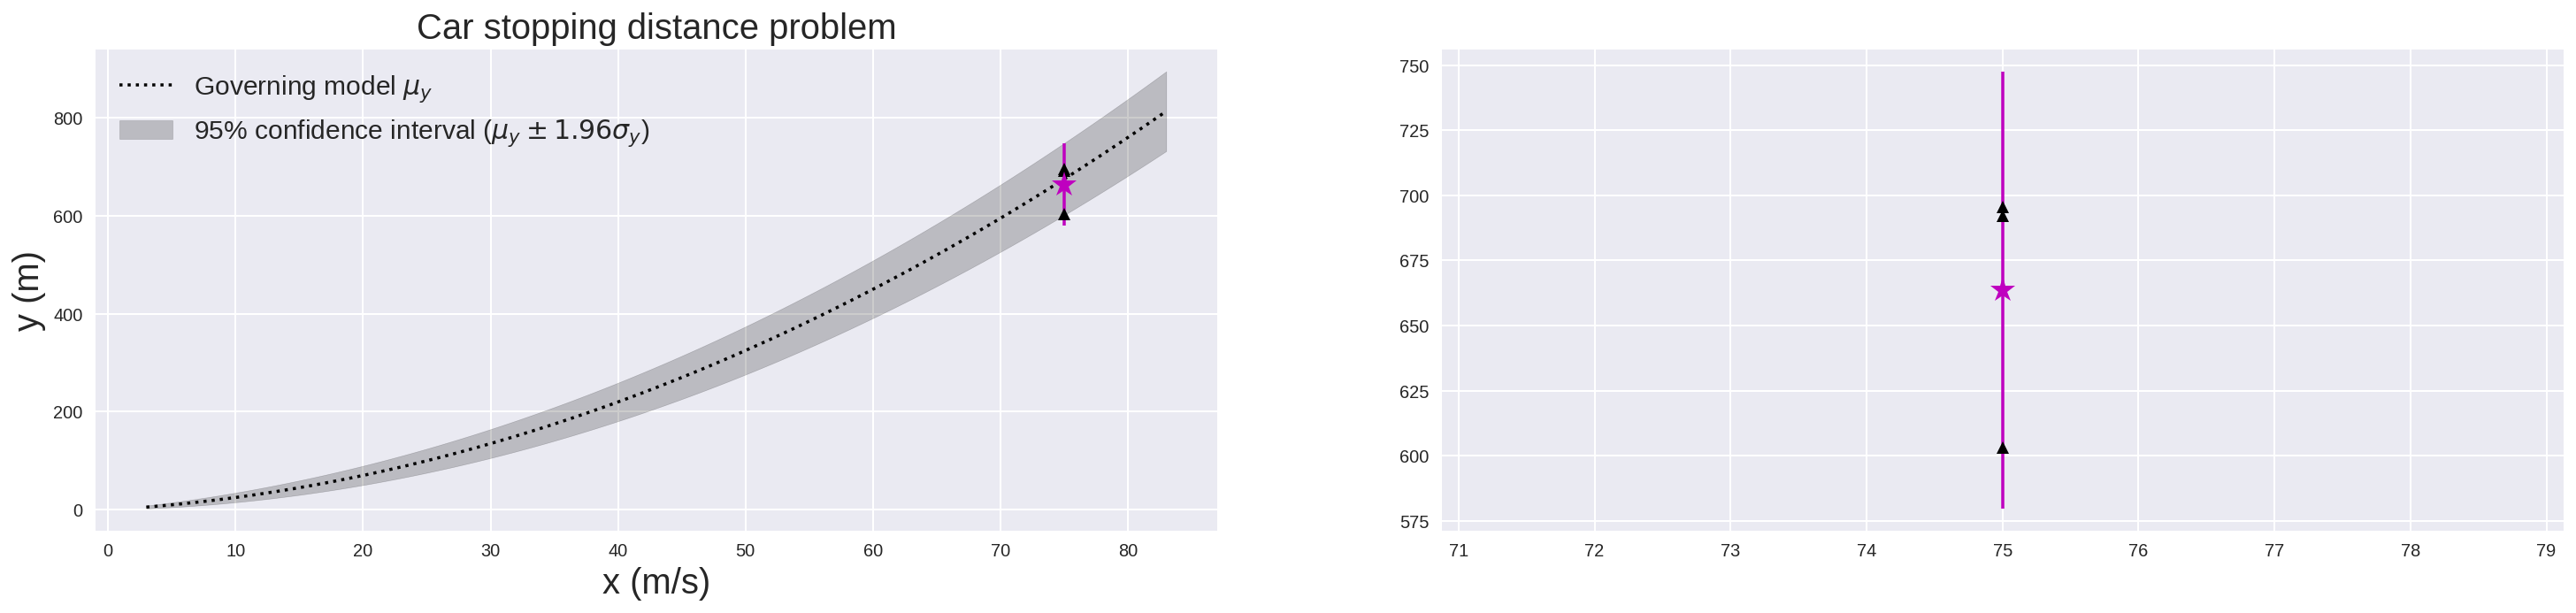

In [4]:
# vvvvvvvvvvv this is just a trick so that we can run this cell multiple times vvvvvvvvvvv
fig_car_new, ax_car_new = plt.subplots(1,2); plt.close() # create figure and close it
if fig_car_new.get_axes():
    del ax_car_new; del fig_car_new # delete figure and axes if they exist
    fig_car_new, ax_car_new = plt.subplots(1,2) # create them again
# ^^^^^^^^^^^ end of the trick ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
N_samples = 3 # CHANGE THIS NUMBER AND RE-RUN THE CELL
real_x = 75; empirical_y = y_for_fixed_x(N_samples); # Empirical measurements of N_samples
empirical_mu_y = np.mean(empirical_y); empirical_sigma_y = np.std(empirical_y); # empirical mean and std
car_fig(ax_car_new[0]) # a function I created to include the background plot of the governing model
for i in range(2): # create two plots (one is zooming in on the error bar)
    ax_car_new[i].errorbar(real_x , empirical_mu_y,yerr=1.96*empirical_sigma_y, fmt='*m', markersize=15);
    ax_car_new[i].plot(75*np.ones_like(empirical_y),empirical_y,'k^')
print("Empirical mean[y] is",empirical_mu_y, "(real mean[y]=675)")
print("Empirical std[y] is",empirical_sigma_y,"(real std[y]=37.5)")
fig_car_new.set_size_inches(25, 5) # scale figure to be wider (since there are 2 subplots)

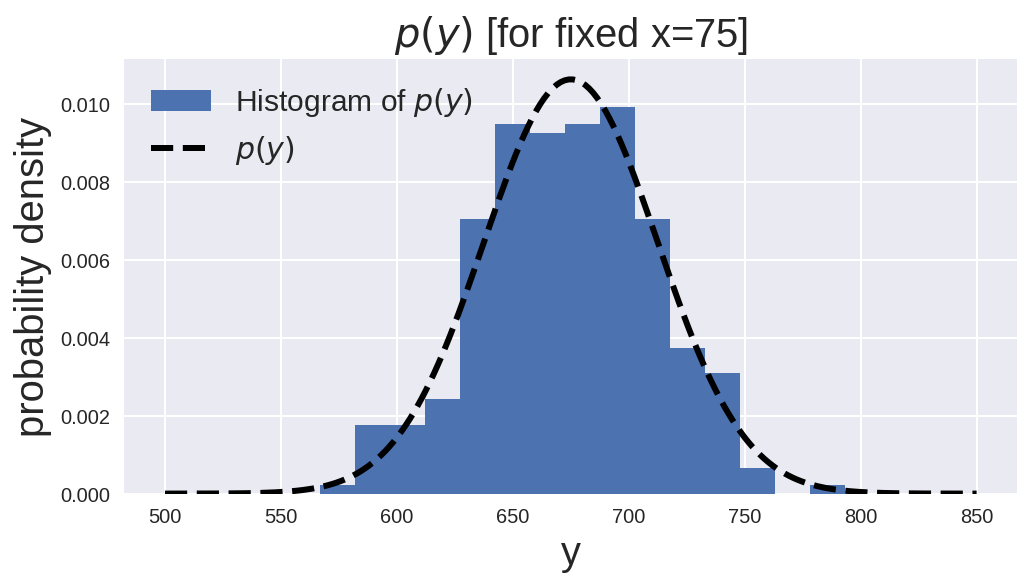

In [5]:
fig_hist, ax_hist_y = plt.subplots()
# Plot the histogram obtained by sampling p(y) with data
samples_y = y_for_fixed_x(N_samples=300)
ax_hist_y.hist(samples_y, bins='auto', # Change Number of samples and see histogram
               density=True, label='Histogram of $p(y)$')  
ax_hist_y.set_title("$p(y)$ [for fixed x=75]", fontsize=20)

# Plot the actual p(y|z) pdf:
yrange = np.linspace(500, 850, 200) # to show the real Gaussian distribution
ax_hist_y.plot(yrange, norm.pdf(yrange, 675, 37.5), 'k--', linewidth = 3, label='$p(y)$')
ax_hist_y.set_xlabel("y", fontsize=20)
ax_hist_y.set_ylabel("probability density", fontsize=20)
ax_hist_y.legend(fontsize=15, loc='upper left');

## Conclusions about $y$ and $z$

* We conclude that $y$ is also an <a title="random variable">rv</a> because $z$ is an <a title="random variable">rv</a>.

* In this case, we empirically found that $p(y)$ is also a Gaussian distribution, just like $z$ but with different parameters. This makes sense because $y$ is just linearly dependent on $z$.

* Also recall that in **Exercise 2** from Lecture 2 we calculated the expected value (mean) and variance of $y$.

These observations lead to the conclusion:

$$
p(y) = \mathcal{N}(\mu_{y}=675,\sigma_{y}^2=37.5^2)
$$

with $p(z) = \mathcal{N}(\mu_z=1.5,\sigma_z^2=0.5^2)$ and for $x=75$.

Recall results from Exercise 2 of Lecture 2:

$$
\mathbb{E}[y]=\mu_{y}=x \mu_z + 0.1 x^2=75\cdot1.5+0.1\cdot75^2=675
$$

$$
\mathbb{V}[y]=\sigma_{y}^2=\sigma_z^2 x^2=0.5^2 \cdot 75^2= 37.5^2
$$

with $p(z) = \mathcal{N}(\mu_z=1.5,\sigma_z^2=0.5^2)$ and for $x=75$.

## Transformation of random variables

This empirical conclusion can be reached analytically from the **change of variables formula**.

This formula says that if $y=f(z)$ and if this function is invertible, i.e. $z=f^{-1}(y)=g(y)$, then:

$$
p_y(y) = p_z\left( g(y) \right) \left| \frac{d}{dy}g(y)\right|
$$

where $g(y) = f^{-1}(z)$.

### Exercise 1

Use the change of variables formula to demonstrate that $p(y)$ is a Gaussian distribution with the expected value and variance determined in Lecture 2 (Exercise 2). In other words, that $p(y)=\mathcal{N}(y|\mu_{y}=x\mu_z+0.1x^2, \sigma_y^2 = \sigma_z^2 x^2)$ when $y=x z + 0.1x^2$.

## Transformation of random variables

For more information about transformation of random variables read Section 2.8 of the book.

The multivariate change of variables formula is:

$$
p_y(\mathbf{y}) = p_z\left( \mathbf{g}(\mathbf{y}) \right) \left| \text{det}\left[\mathbf{J}_g(\mathbf{y})\right]\right|
$$

where $\mathbf{J}_g(\mathbf{y})=\frac{d\mathbf{g}(\mathbf{y})}{d\mathbf{y}^T}$ is the jacobian of $\mathbf{g}$ and $\text{det}\left[\mathbf{J}_g(\mathbf{y})\right]$ is the absolute value of the determinant of $\mathbf{J}_g$ evaluated at $\mathbf{y}$.

## Introducing joint probability density of $y$ and $z$

Just like in Lecture 1 where we talked about **joint probability** of two events, $\text{Pr}(A \wedge B)= \text{Pr}(A, B)$, the **joint probability density** is:

$$
p(y \wedge z)= p(y, z)
$$

- But how do we **calculate** $p(y,z)$?

**If** the two rv's were independent, then it would be: $p(y,z)=p(y)p(z)$

**But...** We know that $y$ is dependent on $z$... So now what do we do?

## What is the joint probability density of $y$ and $z$?

As we saw in Lecture 1, 

$$
p(y, z) = p(y|z)p(z) = p(z|y)p(y) = p(z, y)
$$

Here, we already know $p(y)$ and $p(z)$.

* But what is the **conditional pdf** $p(y|z)$? <font color='blue'>Tell me what you think!</font>

## What is the joint probability density of $y$ and $z$?

Since $y$ and $z$ are dependent, the joint pdf $p(y,z)$ is

$$
p(y, z) = \delta\left(y-(z x+0.1x^2)\right) p(z)
$$

where $p(y|z)=\delta\left(y-(z x+0.1x^2)\right)$ is the Dirac delta pdf, assigning zero probability everywhere except when $y=z x+0.1x^2$.

Recall that $p(z) = \mathcal{N}(\mu_z=1.5,\sigma_z^2=0.5^2)$ (for now you can also forget about $x$ since $x=75$).

* Note: $p(y,z)$ and $p(y|z)$ are pdf's that depend on *both* $y$ and $z$, but the joint pdf $p(y,z)$ has two rv's while the conditional pdf $p(y|z)$ has $z$ conditioned to a value (it's like "removing" the stochasticity of $z$).

## Why do we care about joint pdfs?

In general, from a joint pdf $p(y,z)$ we can obtain $p(y)$ and $p(z)$ simply by **integrating out** wrt the other variable. This is called **marginalizing**:

$$
p(y) = \int p(y,z) dz
$$

$$
p(z) = \int p(y,z) dy
$$

Therefore, $p(y)$ and $p(z)$ are also called **marginal distributions** of $p(y,z)$.

### Exercise 2

Knowing that $p(y, z) = \delta\left(y-(z x+0.1x^2)\right)  \mathcal{N}(z|\mu_z,\sigma_z^2)$, calculate $p(y)$ and $p(z)$.

## In general, do we know the true conditional distribution $p(y|z)$?

Unfortunately, we usually don't know the true conditional pdf $p(y|z)$ because $z$ is hidden!

(Remember: we are cheating with the *car stopping distance problem* because we already know that $y=zx+0.1x^2$)

In general, we don't know the true relationship between $y$ and $z$...

* So, what can we do?

We can **observe** the effect caused by the hidden $z$ in $y$ by taking measurements of $y$.

In other words, within the measurements of $y$ (which we call data $\mathcal{D}_y$) lies the *effect* of the hidden $z$.

* The Bayes' rule provides a way to estimate the distribution of the hidden rv $z$ given data $\mathcal{D}_y$.

### Side note: conditional moments (book Section 2.2.5.4)

On purpose, I skipped talking about conditional moments in Lecture 1...

But now that we talked about conditional pdf's, it's a good time to introduce this.

We can calculate the expected value and variance of an rv that is dependent on another rv with the following two laws.

#### Law of iterated expectations

$$
\mathbb{E}[y] = \mathbb{E}\left[\mathbb{E}[y|z]\right]
$$

#### Law of total variance (or conditional variance formula)

$$
\mathbb{V}[y] = \mathbb{E}\left[\mathbb{V}[y|x]\right]+\mathbb{V}\left[\mathbb{E}[y|z]\right]
$$

## Remember the amazing Bayes' rule

Bayes’ rule: a formula for computing the probability distribution over possible values of an unknown (or hidden) quantity $z$ given some observed data $y$:

$$
p(z|y) = \frac{p(y|z) p(z)}{p(y)}
$$

Bayes' rule follows automatically from the identity: $p(z|y) p(y) = p(y|z) p(z) = p(y,z) = p(z,y)$

## Bayes' rule
$\require{color}$
The pdfs we have been discussing in this lecture are what enable us to create ML models via the Bayes' rule when we apply it on **observed data** $\mathcal{D}_y$:

$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)}
$$

* ${\color{red}p(z)}$ is the **prior** distribution: this term represents what we know (or what we believe we know!) about possible values of the unknown (hidden) <a title="random variable">rv</a> $z$ before we see any data.

## Bayes' rule
$\require{color}$
The pdfs we have been discussing in this lecture are what enable us to create ML models via the Bayes' rule when we apply it on **observed data** $\mathcal{D}_y$:

$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)}
$$

* $\require{color}{\color{blue}p(y | z)}$ is the **observation** distribution (not yet the likelihood!): represents the distribution over the possible outcomes $y$ we expect to see given a particular hidden variable $z$.
    - When we evaluate the observation distribution $p(y | z)$ at a point corresponding to the actual observations, $y=\mathcal{D}_y$, we get the function $p(y=\mathcal{D}_y|z)$:
        * ${\color{blue}p(y=\mathcal{D}_y|z)}$ is the **likelihood** function: it is a function of $z$, since $y$ is *fixed* to the observations $\mathcal{D}_y$, but **it is not a probability distribution** (it does not sum to one).

## Bayes' rule
$\require{color}$
The pdfs we have been discussing in this lecture are what enable us to create ML models via the Bayes' rule when we apply it on **observed data** $\mathcal{D}_y$:

$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)}
$$

* $p(y=\mathcal{D}_y)$ is the **marginal likelihood**, which is obtained by *marginalizing* over the unknown $z$.

## Bayes' rule
$\require{color}$
The pdfs we have been discussing in this lecture are what enable us to create ML models via the Bayes' rule when we apply it on **observed data** $\mathcal{D}_y$:

$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)}
$$

* ${\color{green}p(z|y=\mathcal{D}_y)}$ is the **posterior**, which represents our *belief state* about the possible values of the unknown $z$.

### A note about the term "distribution"

The term distribution can mean two things:
1. For **continuous** <a title="random variables">rv's</a>, the term *distribution* means *probability density function* (<a title="probability density function">pdf</a>).

2. For **discrete** <a title="random variables">rv's</a> the term *distribution* means *probability mass function* (<a title="probability mass function">pmf</a>), as we will see later in the course.

We won't talk about categorical distributions or <a title="probability mass functions">pmf's</a> for a while. So, for now, when you see the term *distribution* it is the same as saying <a title="probability density function">pdf</a>.

## Summary of Bayes' rule
$\require{color}$
$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)} = \frac{ {\color{magenta}p(y=\mathcal{D}_y, z)} } {p(y=\mathcal{D}_y)}
$$

* ${\color{red}p(z)}$ is the **prior** distribution
* ${\color{blue}p(y=\mathcal{D}_y|z)}$ is the **likelihood** function
* ${\color{magenta}p(y=\mathcal{D}_y, z)}$ is the **joint likelihood** (product of likelihood function with prior distribution)
* $p(y=\mathcal{D}_y)$ is the **marginal likelihood**
* ${\color{green}p(z|y=\mathcal{D}_y)}$ is the **posterior**

We can write Bayes' rule as <font color='green'>posterior</font> $\propto$ <font color='blue'>likelihood</font> $\times$ <font color='red'>prior </font>, where we are ignoring the denominator $p(y=\mathcal{D}_y)$ because it is just a **constant** independent of the hidden variable $z$.

### See you next class

Have fun!